In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prophet import Prophet
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

sns.set_theme()

d:\GitHub\itmo_timeseries\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
class DataProcesser:
    def __init__(self, sales_path, prices_path, dates_path):
        self.sales = pd.read_csv(sales_path)
        self.prices = pd.read_csv(prices_path)
        self.dates = pd.read_csv(dates_path)
        print('Данные загружены')

    def get_holidays(self) -> pd.DataFrame:
        dates_data = self.dates.copy()
        dates_data['date'] = pd.to_datetime(dates_data['date'])
        dates_data['event'] = dates_data['event_name_1'].combine_first(
            dates_data['event_name_2']
        )
        holidays = dates_data.dropna(subset=['event'])[['date', 'event']]
        return holidays.rename(columns={'date': 'ds', 'event': 'holiday'})

    def get_processed_data(self, art) -> pd.DataFrame:
        if not art:
            raise ValueError('Укажите артикул (item_id)')

        df = (
            self.dates.merge(self.sales, on='date_id')
            .merge(self.prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
            .sort_values(by='date')
        )

        df['is_weekend'] = df['wday'].apply(lambda x: 1 if x < 3 else 0)
        df = pd.get_dummies(df, columns=['event_type_1'], prefix='type', dtype=int)

        drop_cols = [
            'wm_yr_wk',
            'year',
            'event_name_1',
            'event_name_2',
            'event_type_2',
            'weekday',
        ]
        for col in ['CASHBACK_STORE_1', 'CASHBACK_STORE_3']:
            if col in df.columns:
                drop_cols.append(col)

        df = df.drop(columns=drop_cols, errors='ignore')
        df['date'] = pd.to_datetime(df['date'])
        df = df.rename(columns={'date': 'ds', 'cnt': 'y'})
        df = df[df.item_id == art]
        self.data = df
        return df

    def get_features(self, data) -> pd.DataFrame:
        return data.drop(columns=['ds', 'y'])

    def get_split_data(self, data, test_size=90) -> tuple:
        train = data.iloc[:-test_size].copy()
        test = data.iloc[-test_size:].copy()

        mean_sell_price = train['sell_price'].mean()
        train['sell_price'] = train['sell_price'].fillna(mean_sell_price)
        test['sell_price'] = test['sell_price'].fillna(mean_sell_price)

        return train, test

In [3]:
class SalesForecaster:
    def __init__(self, path: str | None = None):
        self.model = None
        self.data = None

        if path:
            with open(path, 'rb') as f:
                self.model = pickle.load(f)

            print(f'Модель загружена из {path}')

    def fit(self, data, holidays=None) -> None:
        self.data = data
        self.model = Prophet(holidays=holidays) if holidays is not None else Prophet()

        optional_regressors = [
            'CASHBACK_STORE_2',
            'type_Cultural',
            'type_Sporting',
            'type_Religious',
            'type_National',
            'is_weekend',
            'sell_price',
        ]
        for reg in optional_regressors:
            if reg in data.columns:
                self.model.add_regressor(reg)

        self.model.fit(data)
        print('Модель обучена')

    def predict_period(self, features, num_days: int) -> pd.DataFrame:
        future = self.model.make_future_dataframe(periods=num_days)  # type: ignore
        future = future[-num_days:].reset_index(drop=True)
        features = features.reset_index(drop=True)

        if len(features) != num_days:
            raise ValueError(f'Ожидается {num_days} строк, получено {len(features)}')

        for col in features.columns:
            future[col] = features[col].values

        return self.model.predict(future)  # type: ignore

    def forecast(self, features, horizon='month') -> pd.DataFrame:
        days = {'week': 7, 'month': 30, 'quarter': 90}[horizon]
        return self.predict_period(features, days)

    def get_metrics_report(self, y_true, y_pred) -> pd.DataFrame:
        mse = mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred, symmetric=True)
        mae = mean_absolute_error(y_true, y_pred)

        return pd.DataFrame(
            [mse, mape, mae], index=['mse', 'mape', 'mae'], columns=['value']
        )

    def save_model(self, path='prophet_model.pkl') -> None:
        if self.model is None:
            raise ValueError('Модель не обучена — невозможно сохранить')

        with open(path, 'wb') as f:
            pickle.dump(self.model, f)

        print(f'Модель сохранена в {path}')

    def plot_forecast(self, test_df, forecast_df, item_id) -> None:
        plt.figure(figsize=(12, 4))
        plt.plot(test_df['ds'], test_df['y'], label='Тестовый ряд', marker='o')
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Прогноз', marker='x')
        plt.fill_between(
            forecast_df['ds'],
            forecast_df['yhat_lower'],
            forecast_df['yhat_upper'],
            color='gray',
            alpha=0.3,
            label='Доверительный интервал',
        )
        plt.title(f'Прогноз продаж {item_id}')
        plt.xlabel('Дата')
        plt.ylabel('Продажи')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def forecast_and_plot_all_items(self, processer, holidays, store_id) -> None:
        store_items = sorted(
            processer.sales[processer.sales['store_id'] == store_id]['item_id'].unique()
        )

        _, axes = plt.subplots(5, 3, figsize=(20, 12))
        axes = axes.flatten()

        for i, item_id in enumerate(store_items):
            try:
                df = processer.get_processed_data(art=item_id)
                train, test = processer.get_split_data(df)
                features = processer.get_features(test)

                model = SalesForecaster()
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', category=FutureWarning)
                    model.fit(train, holidays=holidays)
                    preds = model.predict_period(features, num_days=90)

                ax = axes[i]
                ax.plot(test['ds'], test['y'], label='Истина', marker='o')
                ax.plot(preds['ds'], preds['yhat'], label='Прогноз', marker='x')
                ax.fill_between(
                    preds['ds'], preds['yhat_lower'], preds['yhat_upper'], alpha=0.2
                )
                ax.set_title(item_id)
                ax.tick_params(axis='x', rotation=45)
            except Exception as e:
                axes[i].set_title(f'{item_id}\nОшибка')
                print(f'{item_id}: ошибка прогноза — {e}')

        plt.tight_layout()
        plt.suptitle(
            f'Прогнозы по всем артикулам (магазин {store_id})', fontsize=16, y=1.02
        )
        plt.legend(loc='upper right')
        plt.show()

# Данные по первому магазину

In [4]:
processer = DataProcesser(
    sales_path='../data/shop_sales.csv',
    prices_path='../data/shop_sales_prices.csv',
    dates_path='../data/shop_sales_dates.csv',
)

holidays = processer.get_holidays()

art = 'STORE_1_546'
data = processer.get_processed_data(art=art)
data_train, data_test = processer.get_split_data(data, test_size=90)

data.tail()

Данные загружены


,ds,wday,month,date_id,CASHBACK_STORE_2,item_id,store_id,y,sell_price,is_weekend,type_Cultural,type_National,type_Religious,type_Sporting
81667,2016-01-17,2,1,1815,0,STORE_1_546,STORE_1,5,5.98,1,0,0,0,0
81712,2016-01-18,3,1,1816,0,STORE_1_546,STORE_1,3,5.98,0,0,1,0,0
81757,2016-01-19,4,1,1817,0,STORE_1_546,STORE_1,1,5.98,0,0,0,0,0
81802,2016-01-20,5,1,1818,0,STORE_1_546,STORE_1,2,5.98,0,0,0,0,0
81847,2016-01-21,6,1,1819,0,STORE_1_546,STORE_1,2,5.98,0,0,0,0,0


# Прогноз

In [5]:
model = SalesForecaster()
model.fit(data_train, holidays=holidays)

model.save_model('prophet_model_store_1_546.pkl')

15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена
Модель сохранена в prophet_model_store_1_546.pkl


In [6]:
model = SalesForecaster('prophet_model_store_1_546.pkl')

features_test = processer.get_features(data_test)
forecast = model.predict_period(features_test, num_days=90)
model.get_metrics_report(data_test[['y']], forecast[['yhat']])

Модель загружена из prophet_model_store_1_546.pkl


,value
mse,6.629545
mape,1.079968
mae,2.128255


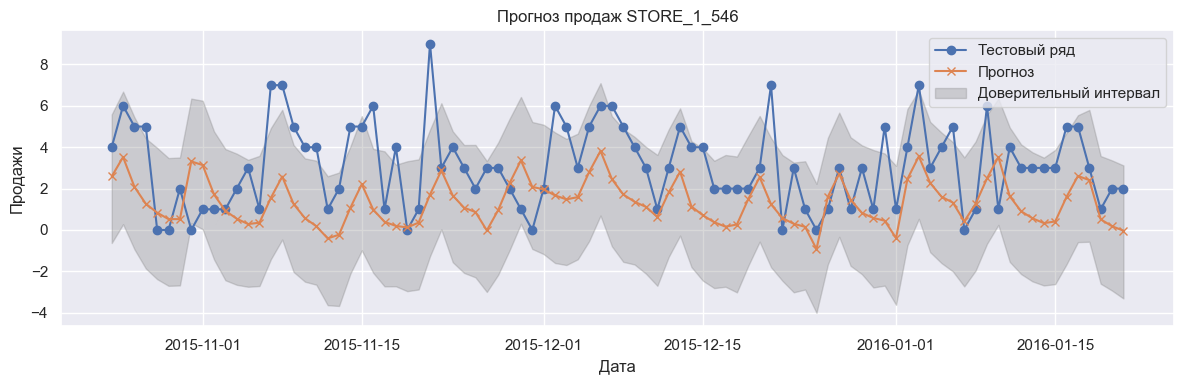

In [7]:
model.plot_forecast(data_test, forecast, art)

15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:48 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:48 - cmdstanpy - INFO - Chain [1] start processing
15:55:48 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:48 - cmdstanpy - INFO - Chain [1] start processing
15:55:49 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:49 - cmdstanpy - INFO - Chain [1] start processing
15:55:49 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


15:55:49 - cmdstanpy - INFO - Chain [1] start processing
15:55:49 - cmdstanpy - INFO - Chain [1] done processing


Модель обучена


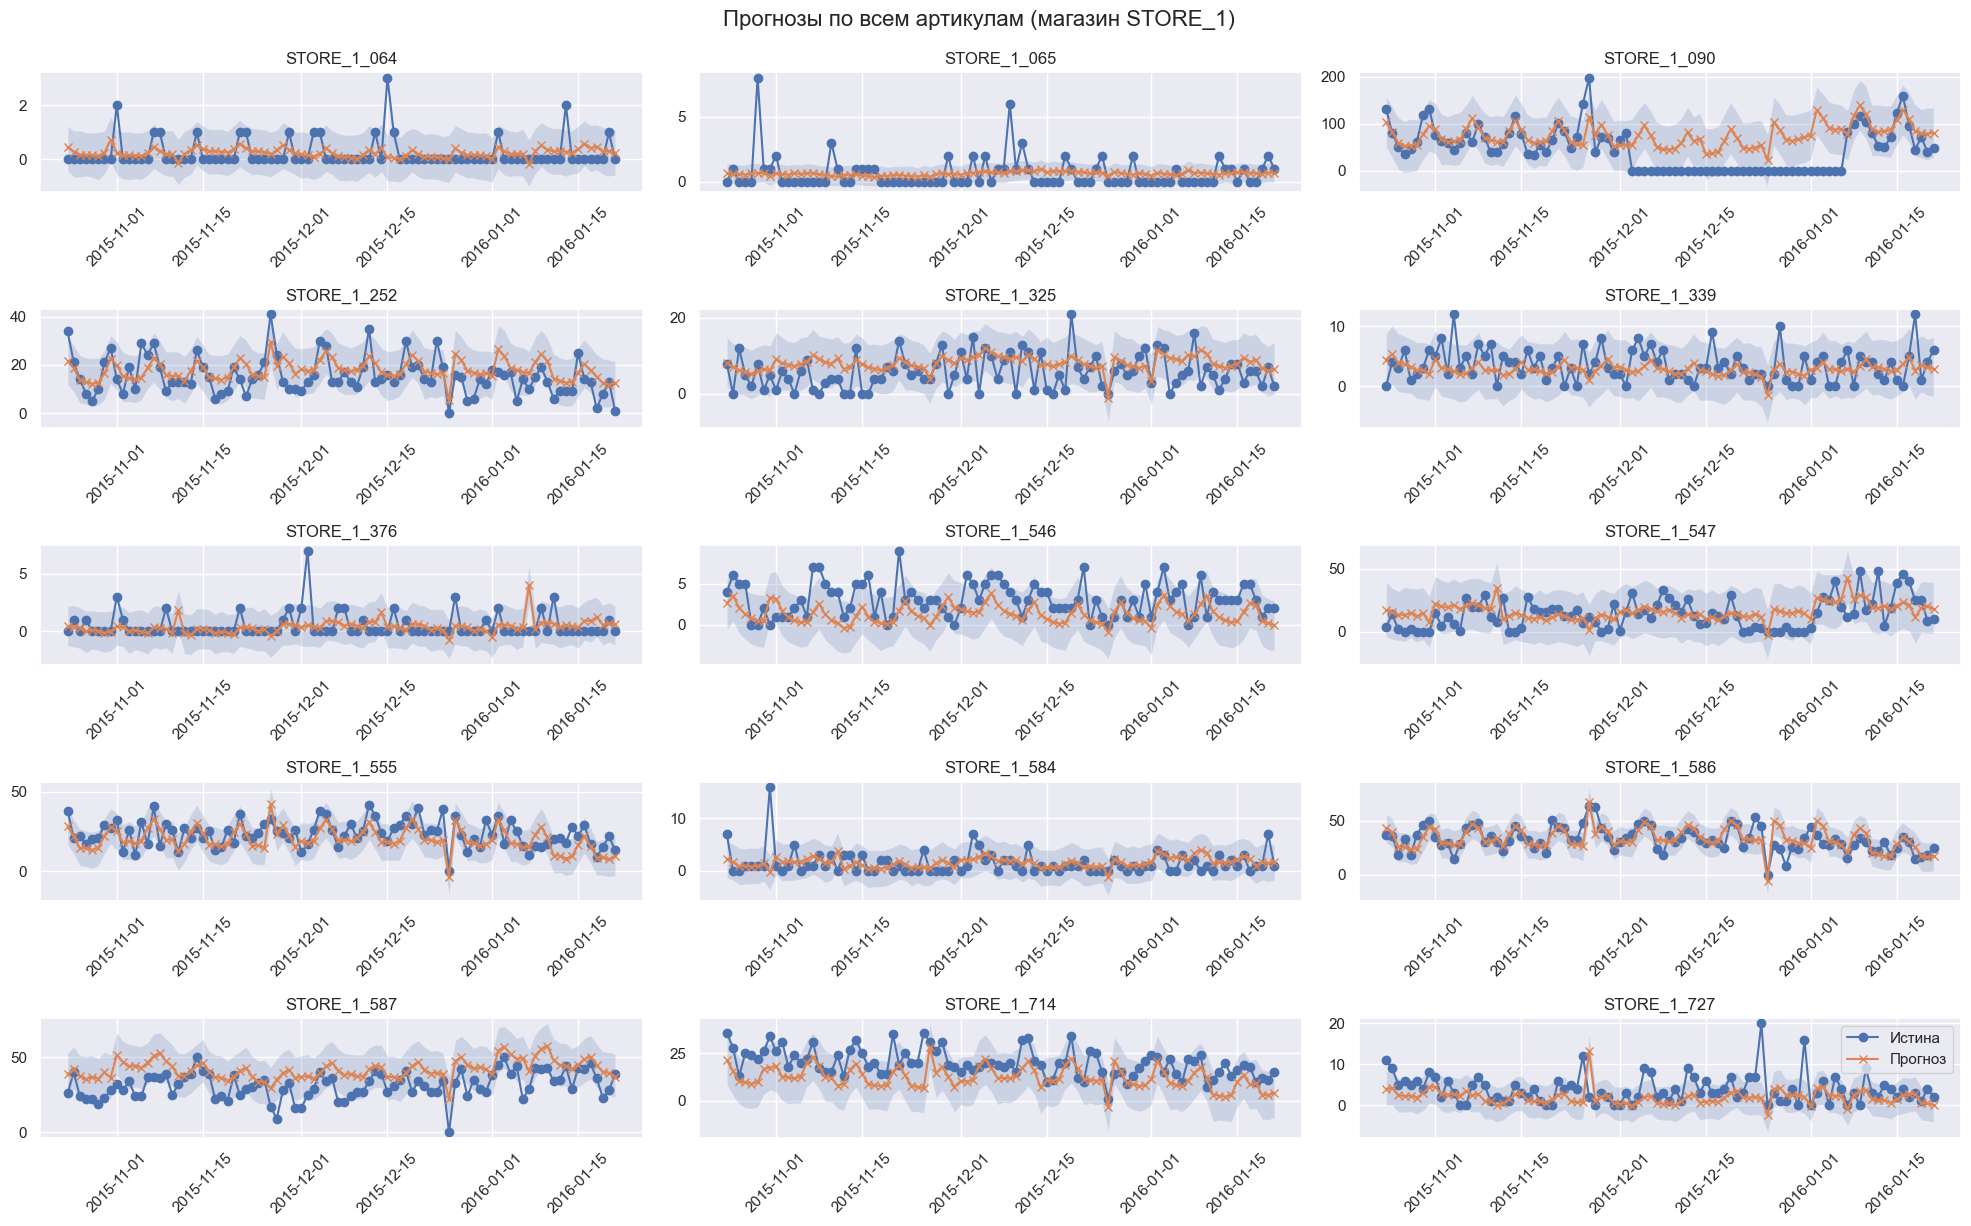

In [8]:
model.forecast_and_plot_all_items(processer, holidays, store_id='STORE_1')

### 1. Какие методы предобработки данных использовали?

- выбран магазин `STORE_1`
- пропущенные значения в ценах оставлены заполнены средними
- добавлен бинарный признак `is_weekend` (сб-вс)
- one-hot-кодирование типа событий `event_type`
- выбросы в продажах выявлены с помощью Z-оценки
- исследована сезонность, тренд и остатки с помощью STL-декомпозиции
- выполнен анализ корреляции между артикулами

### 2. Какие модели пробовали? Почему пробовали именно их?

- использована модель `Prophet`, так как:
  - нативно учитывает праздники (регрессоры) и доп. признаки
  - выдает неплохой прогноз

### 3. Как проверяете качество модели? На каких данных?
Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

- тестовая выборка: последние 90 дней
- метрики:
  - `MAE`, `MAPE`, `MSE` - как самые популярные и понятные технически

### 4. Какое итоговое качество модели на тестовом датасете?

- визуальное сравнение фактических и предсказанных продаж доступно выше
